In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.models import Sequential,load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import time 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os
from os.path import isfile, exists, isdir, join

import shutil

Using TensorFlow backend.


In [11]:
keras.__version__

'2.2.4'

# For Jetson TX2

In [2]:
from keras import backend as K
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

# Define Constant Variables

In [3]:
CNN_MODEL = 'MagmaCnnClassifier.hdf5'
BATCH_SIZE = 256
EPOCH = 5
OPTIMIZER = Adam()

MODEL_NAME = CNN_MODEL
DATA_SHAPE = (100,100,3)
TARGET_SHAPE = 8
TRAIN_DIR = "./data/train"
TEST_DIR = "./data/test"
RESULT_PREDICTION_CALLBACK = None

# Data preprocessing

### create predict_dir by move random pictures from test_dir  

#### remove and copy test_dir

In [14]:
TEST_COPY_DIR = './data/test_dir'
PREDICT_DIR = './data/predict_dir'

# delete folder if exist
if exists(TEST_COPY_DIR) and isdir(TEST_COPY_DIR):
    shutil.rmtree(TEST_COPY_DIR)
print('remove if exist test_dir success')

if exists(PREDICT_DIR) and isdir(PREDICT_DIR):
    shutil.rmtree(PREDICT_DIR)
print('remove if exist predict_dir success')

#copy test as test_dir, there are result as list of copy files
# from distutils.dir_util import copy_tree
# copy_tree('./data/test','./data/test_dir')
from subprocess import call
call(['cp','-a', TEST_DIR, TEST_COPY_DIR])
print('copy test to test_dir success')

remove if exist test_dir success
remove if exist predict_dir success
copy test to test_dir success


#### create predict_dir and random moving images

In [15]:
#random select images
CATEGORIES = ['0','1','2','3','4','5','6','7']
IMAGES_PER_FOLDER = 1

import random
for category in CATEGORIES:
    
    path_ct = join(TEST_COPY_DIR,category)
    path_pd = join(PREDICT_DIR, category)
    
    if not exists(path_pd):
        os.makedirs(path_pd)
    
    image_list = os.listdir(path_ct)
    random.shuffle(image_list)
    
    for img in image_list[:IMAGES_PER_FOLDER]:
        path_src = join(path_ct,img)
        path_des = join(path_pd,img)
        shutil.move(path_src, path_des)
    
    print('copy - category:',category, image_list[:IMAGES_PER_FOLDER])
    
    

copy - category: 0 ['5005.png']
copy - category: 1 ['4769.png']
copy - category: 2 ['3871.png']
copy - category: 3 ['1326.png']
copy - category: 4 ['5201.png']
copy - category: 5 ['8885.png']
copy - category: 6 ['6399.png']
copy - category: 7 ['6038.png']


### create generator

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1 / 255)

train_generator = train_datagen.flow_from_directory(
    directory = TRAIN_DIR ,
    target_size = DATA_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    directory = TEST_COPY_DIR, # use test data that be splited for prediction
    target_size = DATA_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 4917 images belonging to 8 classes.
Found 1222 images belonging to 8 classes.


# Build Model

In [17]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=DATA_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(rate=0.5),
    Dense(units=512, activation='relu'),
    Dense(units=TARGET_SHAPE, activation='softmax'),
])

model.summary()

model.compile(loss='categorical_crossentropy',
                    optimizer=OPTIMIZER,
                    metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         147584    
__________

# Train the Model

Tensorboard to keep log using log_dir<br>
Start Tensorboard UI <br>
$ tensorboard --logdir='logs/'<br>
http://tegra-ubuntu:6006/ <= link for tensorboard ui

In [18]:
sub_dir = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())
tb_cb = TensorBoard(log_dir='./logs/'+sub_dir,
                    #histogram_freq=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    write_grads=True,
                    write_images=True,
                    #update_freq='batch',
                    )
callbacks = [tb_cb]

# train_generator, val_generator declare Data preprocessing

model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//BATCH_SIZE,
                                epochs=EPOCH,
                                validation_data=val_generator,
                              validation_steps=val_generator.n//BATCH_SIZE,
                                callbacks=callbacks)

Epoch 1/5
19/19 [==============================] - 35s 2s/step - loss: 1.7254 - categorical_accuracy: 0.3497 - val_loss: 1.2130 - val_categorical_accuracy: 0.5283
Epoch 2/5
19/19 [==============================] - 36s 2s/step - loss: 1.1625 - categorical_accuracy: 0.5939 - val_loss: 0.8591 - val_categorical_accuracy: 0.7133
Epoch 3/5
19/19 [==============================] - 34s 2s/step - loss: 0.8958 - categorical_accuracy: 0.6973 - val_loss: 0.6247 - val_categorical_accuracy: 0.7919
Epoch 4/5
19/19 [==============================] - 32s 2s/step - loss: 0.7392 - categorical_accuracy: 0.7430 - val_loss: 0.5060 - val_categorical_accuracy: 0.8313
Epoch 5/5
19/19 [==============================] - 31s 2s/step - loss: 0.6298 - categorical_accuracy: 0.7793 - val_loss: 0.4309 - val_categorical_accuracy: 0.8602


# Save model

In [19]:
model.save('data/'+CNN_MODEL)

# Load model

In [20]:
if isfile('./data/' + MODEL_NAME):
    model = load_model(filepath='./data/' + MODEL_NAME)
    model.summary()
else:
    raise Exception("--MODEL COULD NOT LOADED")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         147584    
__________

# TensorBoard

# Prediction

In [21]:
images = []
for category in CATEGORIES:
    path_pd = join(PREDICT_DIR, category)
    class_num = CATEGORIES.index(category)
    image_list = os.listdir(path_pd)
    
    for img in image_list:
        images.append([join(path_pd,img),class_num,img])

print(images)
print(images[0][0])

[['./data/predict_dir/0/5005.png', 0, '5005.png'], ['./data/predict_dir/1/4769.png', 1, '4769.png'], ['./data/predict_dir/2/3871.png', 2, '3871.png'], ['./data/predict_dir/3/1326.png', 3, '1326.png'], ['./data/predict_dir/4/5201.png', 4, '5201.png'], ['./data/predict_dir/5/8885.png', 5, '8885.png'], ['./data/predict_dir/6/6399.png', 6, '6399.png'], ['./data/predict_dir/7/6038.png', 7, '6038.png']]
./data/predict_dir/0/5005.png


-
---
-----
0 ['./data/predict_dir/0/5005.png', 0, '5005.png'] [[0.972 0.001 0.    0.001 0.014 0.    0.001 0.012]]
1 ['./data/predict_dir/1/4769.png', 1, '4769.png'] [[0.001 0.993 0.    0.    0.004 0.002 0.    0.   ]]
2 ['./data/predict_dir/2/3871.png', 2, '3871.png'] [[0.    0.    0.563 0.001 0.    0.    0.004 0.431]]
3 ['./data/predict_dir/3/1326.png', 3, '1326.png'] [[0.    0.016 0.051 0.618 0.001 0.148 0.01  0.155]]
4 ['./data/predict_dir/4/5201.png', 4, '5201.png'] [[0.    0.018 0.    0.017 0.875 0.089 0.    0.001]]
5 ['./data/predict_dir/5/8885.png', 5, '8885.png'] [[0.002 0.006 0.061 0.145 0.007 0.655 0.003 0.121]]
6 ['./data/predict_dir/6/6399.png', 6, '6399.png'] [[0.    0.    0.    0.012 0.005 0.    0.982 0.   ]]
7 ['./data/predict_dir/7/6038.png', 7, '6038.png'] [[0.004 0.044 0.002 0.004 0.    0.001 0.    0.945]]


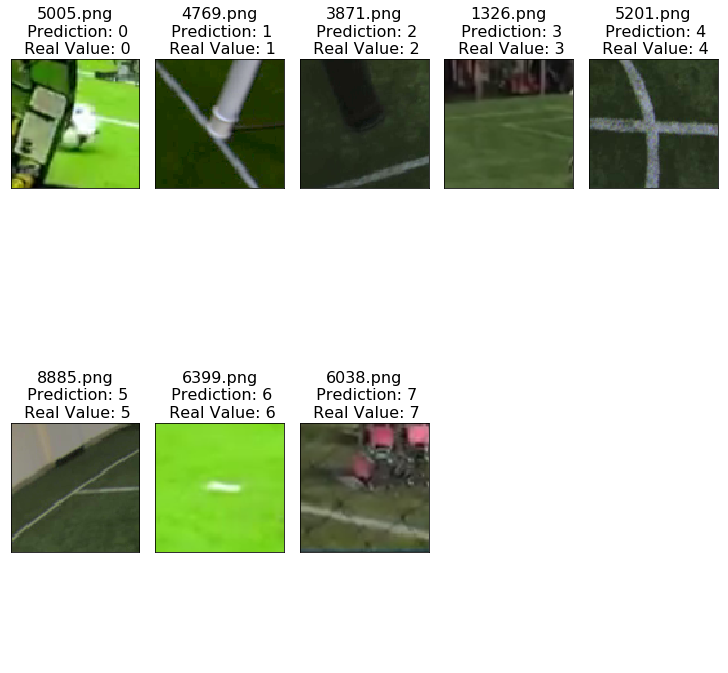

In [22]:
print('-')
COLS = 5
rows = len(images)//COLS+1
print('---')
fig, axes =  plt.subplots(nrows=rows, ncols=COLS, figsize=(10,10), constrained_layout=True)
print('-----')
# delete unused axes
for i in range( -(rows*COLS-len(images)),0):
    fig.delaxes(axes[rows-1,i])
    
for idx, image in enumerate(images):
    col = idx%COLS
    row = idx//COLS
    
    img = load_img(path=image[0], color_mode='rgb', target_size=DATA_SHAPE)
    #img = img_to_array(img)
    img2predict = img.copy()
    img2predict = img_to_array(img2predict)
    img2predict = np.expand_dims(img2predict,0)
    img2predict /= 255
    #int(img2predict)
      
    pred = model.predict(img2predict)
    pred = np.round(pred, 3)
    #pred = np.argmax(pred)
    print(idx, image, pred) 
    img = np.squeeze(img)
    axes[row,col].imshow(img,aspect='equal')
    axes[row,col].set_title('{}\n Prediction: {}\n Real Value: {}'.format(image[2], np.argmax(pred), image[1]),fontsize=16)
    axes[row,col].tick_params(bottom=False, left=False,  labelleft=False, labelbottom=False)

plt.show()

# Visualizing

### 1. Intermediate activation

load image 43.png


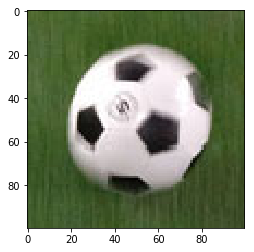

first_layer shape:  (1, 98, 98, 32)
example 4th channel in 1st layer


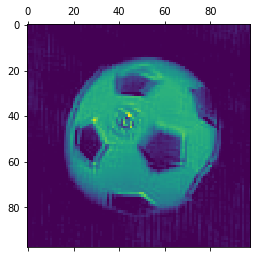

/home/nvidia/dev/py3_keras/lib/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


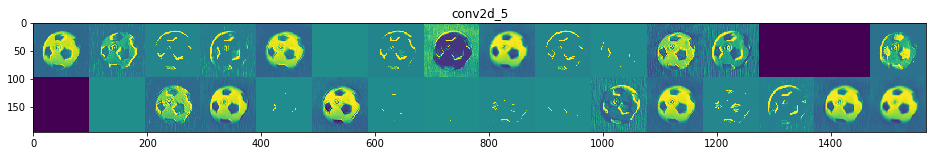

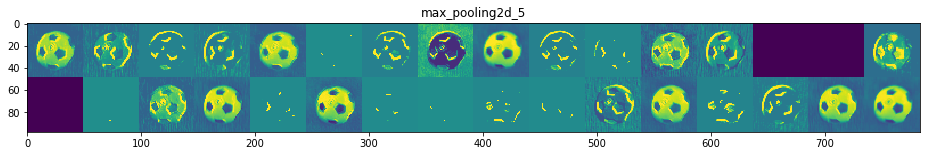

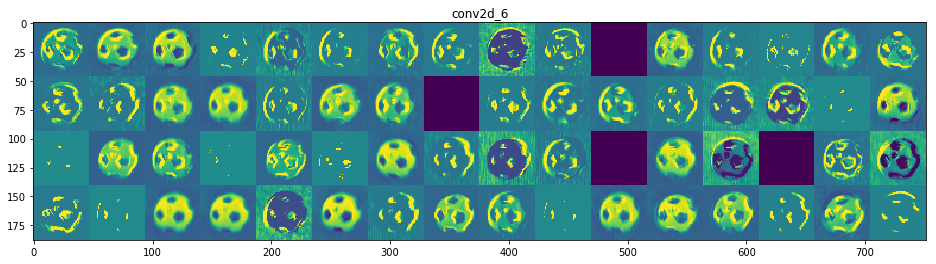

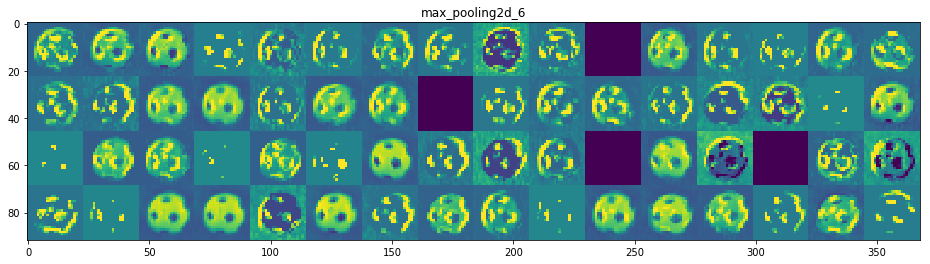

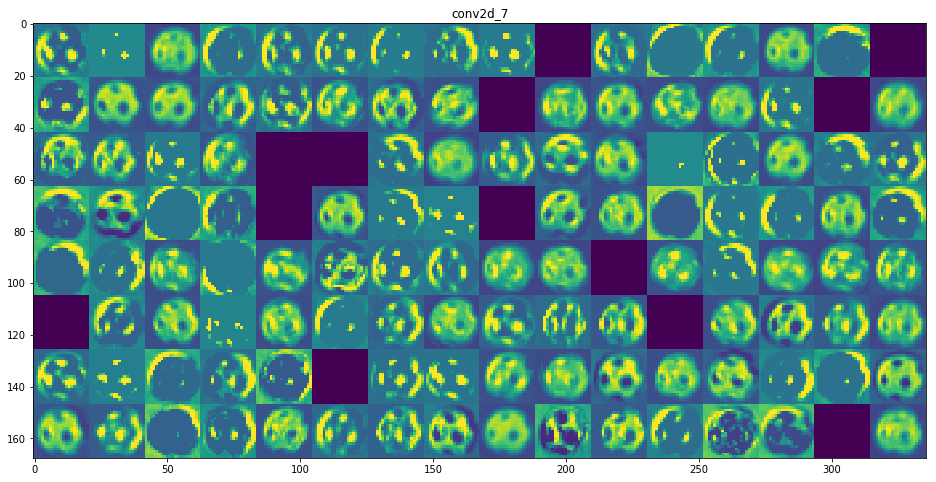

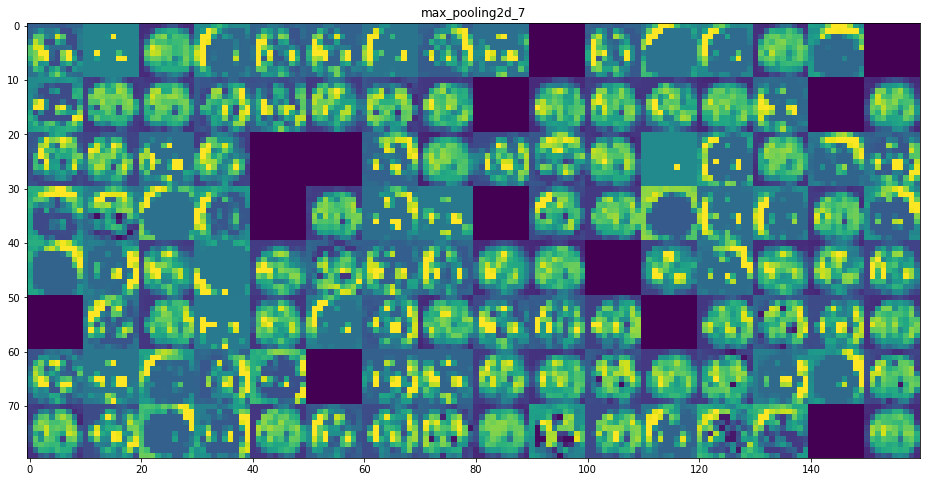

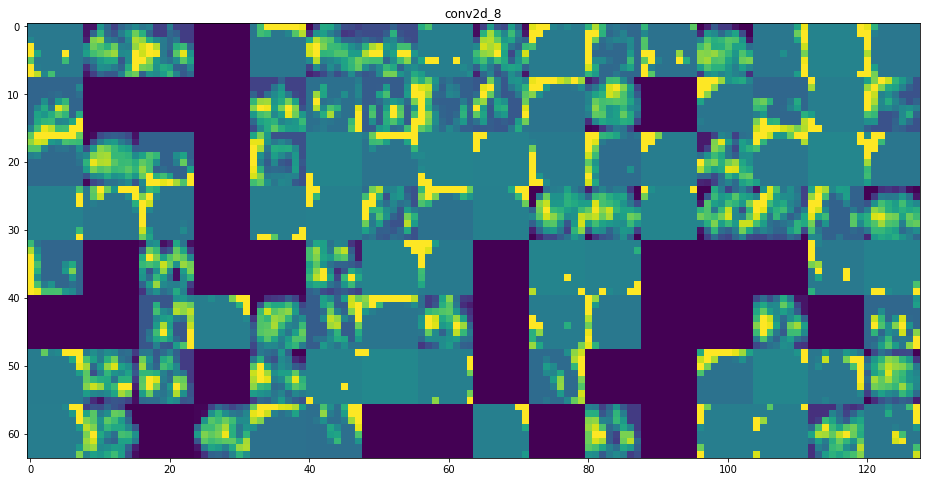

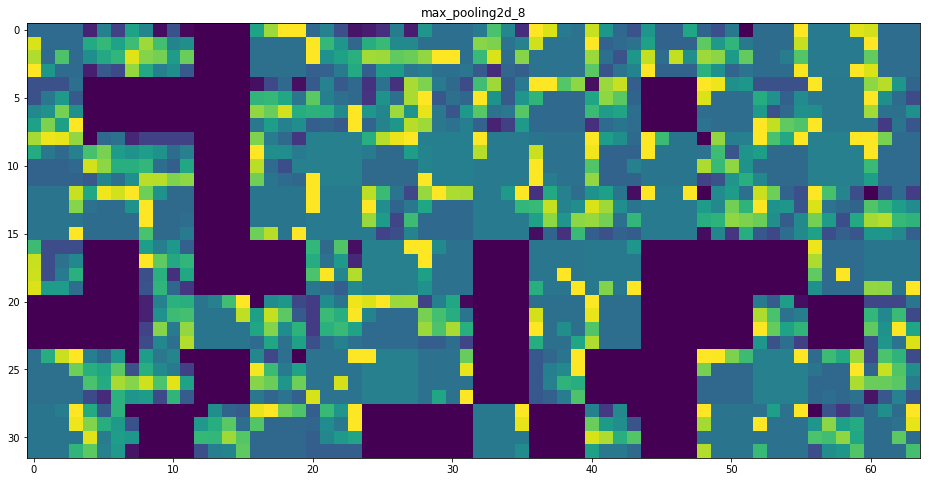

In [23]:
image = load_img(path=join(TEST_DIR+'/0','43.png'), color_mode='rgb', target_size=DATA_SHAPE)
image_tensor = image.copy()
image_tensor = img_to_array(image_tensor)
image_tensor = np.expand_dims(image_tensor,axis=0)
image_tensor /= 255

print('load image 43.png')
plt.imshow(image_tensor[0])
plt.show()

# only consider first 8 layers
layer_outputs = [layer.output for layer in model.layers[:8]]
#layer_outputs = [model.get_layer(index=idx).output for idx in range(len(model.layers)-4)]

activation_model = Model(inputs=model.input,outputs=layer_outputs)

activations = activation_model.predict(image_tensor)

first_layer_activation = activations[0]
print('first_layer shape: ',first_layer_activation.shape)

print('example 4th channel in 1st layer')
plt.matshow(first_layer_activation[0,:,:,4], cmap='viridis') # 4th channel in the first layer 
plt.show()

# add layer name
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # display feature map
    
    n_features = layer_activation.shape[-1] # number of features
    size = layer_activation.shape[1] # feature map shape (1,size,size,n_features)
    n_cols = n_features // images_per_row
    
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            #post process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col*size:(col+1)*size, row*size:(row+1)*size] = channel_image #disply the grid
            
    scale = 1. / size
    plt.figure(figsize=(scale*display_grid.shape[1],scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### 2. Heatmaps of class activation

#### Loading VGG16 and preprocessing an input image for VVG16

In [25]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

MemoryError: 

In [ ]:
img_path = join(TEST_DIR+'/0','43.png')
img = load_img(img_path, target_size=(224,224)) # must be 224,224
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

In [ ]:
preds = model.predict(x)
print('Predict:', decode_predictions(preds, top=3)[0])

np.argmax(preds[0])

#### Setting up the GRAD-CAM algorithm

In [ ]:
ball43_output = model.output[:, np.argmax(preds[0])] # 805 = np.argmax(preds[0])

last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(ball43_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

#### Heatmap post-preprocesing

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

#### heatmap with original picture 

In [ ]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('./data/43heatmap.jpg', superimposed_img)

In [ ]:
image = load_img(path=join('./data/43heatmap.jpg'), color_mode='rgb', target_size=DATA_SHAPE)

print('load heatmap image 43.png')
plt.imshow(image)
plt.show()

### 3. Convnet filters 

#### Defining the loss tensor for filter visualization

In [4]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])


SIZE = 100

In [5]:
# Obtaining the gradient of the loss with regard to the input
grads = K.gradients(loss, model.input)[0]

# Gradient-normalization trick
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

#### Fetching Numpy output values given Numpy input values

In [6]:
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, SIZE, SIZE, 3))])

#### Loss maximization via stochastic gradient descent

In [7]:
input_img_data = np.random.random((1, SIZE, SIZE, 3)) * 20 + 128.
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

#### Utility function to convert a tensor into a valid image

In [8]:
def deprocess_image(x):
    # Normalizes the tensor:
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # Clips to [0, 1]
    x += 0.5
    x = np.clip(x,0,1)
    
    # Converts to an RGB array
    x *= 255
    x = np.clip(x ,0 ,255).astype('uint8')
    
    return x

#### Function to generate filter visualizations

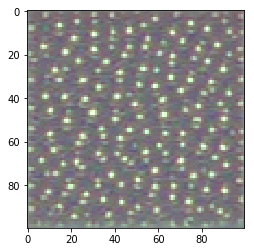

In [9]:
def generate_pattern(layer_name, filter_index, size=SIZE):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

plt.imshow(generate_pattern('block3_conv1', 0))

#### Generating a grid of all filter response patterns in a layer

In [10]:
layer_names = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1']
margin = 5
size = 64

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

In [14]:
import cv2

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern('block3_conv1', i + (j * 8), size=size)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,vertical_start: vertical_end, :] = filter_img
        
cv2.imwrite('./data/filter64_b3c1.jpg', results)

True

load image


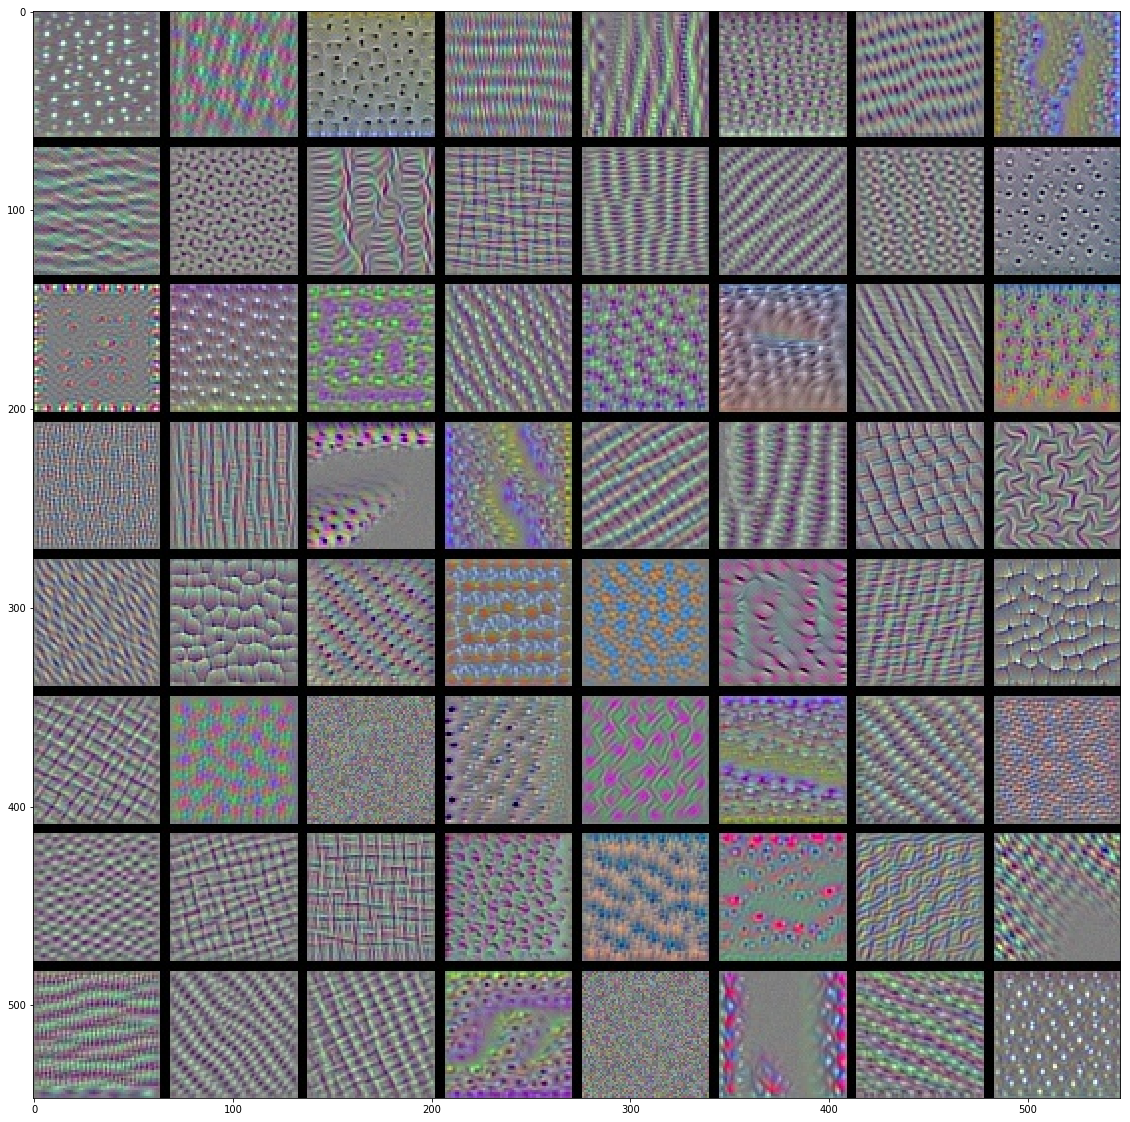

In [18]:
import cv2
image = load_img(path=join('./data/filter64_b3c1.jpg'), color_mode='rgb')

print('load image')
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.show()